## Data Acquisation and Cleaning

First, import the libraries and modules used, and use the Path module to create a 'safe' path for the data file, to be recognized in all OS

In [ ]:
from pathlib import Path

import numpy as np # gotta check if np is ever used in my code
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = Path().resolve()

Data_PATH = DATA_DIR / "raw_data" / "w1inhome_dvn.sav"

if not Data_PATH.exists():
    raise FileNotFoundError(f"Could not find dataset at {Data_PATH}")

plt.style.use("seaborn-v0_8-whitegrid")
pd.options.display.float_format = "{:.2f}".format # might want to change these plotting settings for later

Second, load the raw data into a DataFrame object, to perform cleaning operations

In [ ]:
# now time for cleaning into a compact DataFrame:
import pyreadstat # to read the SPSS file
data, meta = pyreadstat.read_sav(Data_PATH) # data contains the data frame. meta contains the metadata and encodings for values     

we have a lot of variables, since this is microdata, from selected variables, I will compute new indices and discard old values used to compute them, this will drastically reduce the number of variables I will be working with.

In [ ]:
data.head() # display first 5 entries

From the in-home interview Notebook, I have obtained the codes for the variables that I am interested in, I have compiled them into a list, called ordered_columns.

The following are the codes with the corresponding interview question:


In [ ]:
ordered_columns = ['AID', 'H1GI1M', 'H1GI1Y', 'BIO_SEX', 'H1GI9', 'IYEAR', 'H1SU1', 'H1SU2', 'H1RM1', 'H1RF1', 'H1FS1', 'H1FS2',
                    'H1FS3', 'H1FS4', 'H1FS5', 'H1FS6', 'H1FS7', 'H1FS8', 'H1FS9', 'H1FS10', 'H1FS11', 'H1FS12', 'H1FS13',
                      'H1FS14', 'H1FS15', 'H1FS16', 'H1FS17', 'H1FS18', 'H1GH18', 'H1GH21', 'H1PF16', 'H1WP10', 'H1PF1',
                        'H1PF2', 'H1PF3', 'H1PF4', 'H1WP9', 'H1WP14', 'H1PF23', 'H1PF24', 'H1PF25', 'H1WP13', 'H1WP1', 'H1WP2',
                          'H1WP3', 'H1WP4', 'H1WP5', 'H1WP6', 'H1WP7', 'H1FV1', 'H1FV2', 'H1FV3', 'H1FV4', 'H1FV5', 'H1FV6', 'H1FV7']

In [ ]:
select_vars_data = data[ordered_columns] # in the new data frame, only include the ordered columns
select_vars_data.head()

Replacing Missingness-corresponding values with NaN:

Now that we have the dataframe with the 56 variables selected, we need to consider missing values.
In the codebook some values that are missing might have several numbers indicating it, so we need 
to replace it with NaN. While looking at the codebook, there were some questions that had different 
values for missingness, so one must accommodate for that fact.


In [ ]:
# Common missing value keywords found in survey data labels
missing_keywords = ['refused', 'don\'t know', 'not applicable', 'legitimate skip', 
                    'missing', 'skip', 'na', 'dk', 'rf']

def extract_missing_codes(value_labels):
    """
    Extract codes that represent missing values based on label text.
    
    Parameters:
    -----------
    value_labels : dict
        Dictionary mapping numeric codes to their text labels
        
    Returns:
    --------
    list : List of codes that represent missing values
    """
    missing_codes = []
    for code, label in value_labels.items():
        label_lower = str(label).lower()
        # Check if any missing keyword appears in the label
        if any(keyword in label_lower for keyword in missing_keywords):
            missing_codes.append(code)
    return missing_codes

# Create a copy to avoid modifying the original dataframe
select_vars_data = select_vars_data.copy()

# Iterate through all selected variables
for col in ordered_columns:
    
    # Skip the ID column - we don't want to mark any IDs as missing
    if col == 'AID':
        continue
    
    # --- Method 1: Extract missing codes from value labels ---
    # This handles cases where missing values are defined in the codebook labels
    value_labels = meta.variable_value_labels.get(col, {})
    
    if value_labels:
        # Extract codes that represent missing values
        missing_codes = extract_missing_codes(value_labels)
        
        if missing_codes:
            # Create replacement dictionary mapping missing codes to NaN
            clean_dict = {code: np.nan for code in missing_codes}
            select_vars_data[col] = select_vars_data[col].replace(clean_dict)
    
    # --- Method 2: Exact missing values from metadata ---
    # This handles cases where missing values are explicitly defined in metadata
    missing_vals = meta.missing_user_values.get(col, [])
    
    if missing_vals:
        # Create dictionary mapping each missing value to NaN
        clean_dict = {int(val): np.nan for val in missing_vals}
        # Replace the missing value codes with NaN
        select_vars_data[col] = select_vars_data[col].replace(clean_dict)

    # --- Method 3: Range-based missingness from metadata ---
    # This handles cases where missing values fall within a specified range (e.g., 96-99)
    missing_ranges = meta.missing_ranges.get(col, [])

    for lo, hi in missing_ranges:
        lo, hi = int(lo), int(hi)
        # Mask all values within the range [lo, hi] as NaN
        select_vars_data[col] = select_vars_data[col].mask(
            select_vars_data[col].between(lo, hi), np.nan
        )

# Display summary of missing values after cleaning 
print(f"Total missing values across all columns: {select_vars_data.isna().sum().sum()}")
print(f"\nMissing values by column:")
print(select_vars_data.isna().sum())

In [ ]:
select_vars_data.head()

Now it turns out that I need to do some reverse-coding for some categories:

In [ ]:
# Reverse code CES-D items (0–3 scale)
cesd_reverse_items = ["H1FS4", "H1FS8", "H1FS11", "H1FS15"]
for col in cesd_reverse_items:
    select_vars_data[col + "_r"] = 3 - select_vars_data[col]

# Reverse code impulsivity (1–5 scale)
select_vars_data["H1PF16_r"] = 6 - select_vars_data["H1PF16"]


In [ ]:
print(select_vars_data[["H1FS4", "H1FS4_r"]].head())
select_vars_data[["H1PF16", "H1PF16_r"]].head()


# Calculation of indices:
I will compress the data corresponding to questions about one category into one index, then I will omitt the categories used for the computations

In [ ]:
# 1. CES-D DEPRESSION SCORE (mean of 18 items)

cesd_items = [
    "H1FS1", "H1FS2", "H1FS3", "H1FS4_r", "H1FS5", "H1FS6",
    "H1FS7", "H1FS8_r", "H1FS9", "H1FS10", "H1FS11_r",
    "H1FS12", "H1FS13", "H1FS14", "H1FS15_r", "H1FS16",
    "H1FS17", "H1FS18"
]

select_vars_data["cesd_score"] = select_vars_data[cesd_items].mean(axis=1)


In [ ]:
# impulsivity index:
select_vars_data["impulsivity"] = select_vars_data["H1PF16_r"]


In [ ]:
# parents-present index:

select_vars_data["mother_present"] = (
    ~select_vars_data["H1RM1"].isin([97, np.nan])
).astype(int)

select_vars_data["father_present"] = (
    ~select_vars_data["H1RF1"].isin([97, 99, np.nan])
).astype(int)

In [ ]:
warmth_items = [
    # Mother warmth/connection
    "H1WP10", "H1PF1", "H1PF2", "H1PF3", "H1PF4", "H1WP9",
    
    # Father warmth/connection
    "H1WP14", "H1PF23", "H1PF24", "H1PF25", "H1WP13"
]
# parental warmth index:
select_vars_data["parental_warmth"] = select_vars_data[warmth_items].mean(axis=1)


In [ ]:
monitoring_items = [
    "H1WP1", "H1WP2", "H1WP3", "H1WP4",
    "H1WP5", "H1WP6", "H1WP7"
]
# parental monitoring index:
select_vars_data["parental_monitoring"] = select_vars_data[monitoring_items].mean(axis=1)


In [ ]:
ace_items_victim = [
    "H1FV1", "H1FV2", "H1FV3", "H1FV4", "H1FV5", "H1FV6"
]
# index showing the vicimization to adverse childhood experiences
select_vars_data["ace_victim"] = (
    select_vars_data[ace_items_victim]
    .replace({1: 1, 2: 1})
    .sum(axis=1)
)


In [ ]:
select_vars_data["suicidal_ideation"] = (
    select_vars_data["H1SU1"] == 1
).astype(int)

# binary value --> returns 1 if the respondent has considered suicide, 0 otherwise


In [ ]:
select_vars_data["suicide_attempt"] = (
    select_vars_data["H1SU2"] > 0
).astype(int)

# binary value --> returns 1 if the respondent attempted suicide atleast once, 0 otherwise

In [ ]:
# Compute simple age (year-level)
select_vars_data["age"] = (
    select_vars_data["IYEAR"] - select_vars_data["H1GI1Y"]
)

Renaming Columns and Annotating Categorical-corresponding Values:

In [ ]:
rename_dict = {
    "AID": "id",
    "BIO_SEX": "sex",
    "H1GI9": "race",
    "IYEAR": "interview_year",
    "H1RM1": "mother_edu",
    "H1RF1": "father_edu",
    "H1SU1": "suicidal_thought_raw",
    "H1SU2": "suicide_attempt_raw",
    "H1GI1Y": "birth_year",     
    "H1GI1M": "birth_month"     
}

select_vars_data = select_vars_data.rename(columns=rename_dict)

# annotate sex

select_vars_data["sex_cat"] = select_vars_data["sex"].map({
    1.0: "Male",
    2.0: "Female"
})


# annotate race

select_vars_data["race_cat"] = select_vars_data["race"].map({
    1.0: "White",
    2.0: "Black",
    3.0: "Native American",
    4.0: "Asian/Pacific Islander",
    5.0: "Other"
})


# annnotate parent education


mother_map = {
    1: "8th grade or less",
    2: "Some high school",
    3: "Trade school (no HS)",
    4: "High school graduate",
    5: "GED",
    6: "Trade school (after HS)",
    7: "Some college",
    8: "College graduate",
    9: "Postgraduate",
    10: "Never attended school"
}

select_vars_data["mother_edu_cat"] = select_vars_data["mother_edu"].map(mother_map)

father_map = mother_map.copy()
father_map[10] = "Never attended school"

select_vars_data["father_edu_cat"] = select_vars_data["father_edu"].map(father_map)


# annotate suicidality (raw items)

select_vars_data["suicidal_thought_cat"] = select_vars_data["suicidal_thought_raw"].map({
    0.0: "No",
    1.0: "Yes"
})

select_vars_data["suicide_attempt_cat"] = select_vars_data["suicide_attempt_raw"].map({
    0.0: "None",
    1.0: "1 time",
    2.0: "2-3 times",
    3.0: "4-5 times",
    4.0: "6+ times"
})


Drop columns (Those used for computing indices)

In [ ]:
columns_to_drop = [
    # raw demographics (keeping only categorical versions)
    "sex",
    "race",
    "mother_edu",
    "father_edu",

    # raw suicidality
    "suicidal_thought_raw",
    "suicide_attempt_raw",

    # CES-D raw items
    *[f"H1FS{i}" for i in range(1, 19)],

    # CES-D reverse-coded items
    "H1FS4_r", "H1FS8_r", "H1FS11_r", "H1FS15_r",

    # impulsivity raw item
    "H1PF16",

    # parental warmth raw items
    "H1PF1", "H1PF2", "H1PF3", "H1PF4",
    "H1PF23", "H1PF24", "H1PF25",

    # parent closeness/caring (raw)
    "H1WP9", "H1WP10", "H1WP13", "H1WP14",

    # autonomy/monitoring items
    "H1WP1", "H1WP2", "H1WP3", "H1WP4",
    "H1WP5", "H1WP6", "H1WP7",

    # violence raw items
    "H1FV1","H1FV2","H1FV3","H1FV4","H1FV5","H1FV6","H1FV7",

    # remove categorical suicidality if not needed
    "suicidal_thought_cat",
    "suicide_attempt_cat",

    # also variables corresponding to the impulsivity question, insomenia, and crying question
    "H1PF16_r",
    "H1GH18",
    "H1GH21"
]

select_vars_data = select_vars_data.drop(columns=columns_to_drop, errors="ignore")


In [ ]:
select_vars_data.info()

In [ ]:
select_vars_data.head(10)

## Data Enrichment

To address the part of my research question that inquires about the variability with respect to socioeconomic groups, I have used the Add Health Public Use Contextual Database, which already links each respondants ID with context variables. These variables were calculated from governmental data namely Block group level data from the Census of Population and Housing, 1990: Summary Tape
File 3A (STF 3A). In other words, the context variables describe the respondant's block of residence.

The next code cells handle the variable selection and cleaning of the contextual data file.

In [ ]:
# preparing the data path
Context_Data_PATH = DATA_DIR / "raw_data" / "w1context_dvn.sav"

if not Context_Data_PATH.exists():
    raise FileNotFoundError(f"Could not find dataset at {Context_Data_PATH}")

In [ ]:
# now time for cleaning into a compact DataFrame:
context_data, context_meta = pyreadstat.read_sav(Context_Data_PATH) # context_data contains the data frame. context_meta contains the metadata and encodings for values     

In [ ]:
context_data.info() # initial inspection of the data

''' as mentioned in the User Documentation, 
the first 3 variables in the public use context database are 
the ID (AID), MATCH (tells if the geocode has been matched, only for the purpose of this project),
and MOVER (Insignificant for this project). The other 29 variables are the main context variables,
also we can observe that there are no missing values reported, this makes sense since the file uses specific integers to denote missingness
(which are numbers 8 and 9)
'''

In [ ]:
# Cleaning:

# I want to drop rows such that MATCH == 0, since if that is the case, then we have no contextual data for this respondant

clean_context = context_data[context_data["MATCH"] != 0].copy() # uses boolean selection, AI-generated (Gemini)
clean_context.info()

In [ ]:
# now we need to select the varaibles:

context_vars = ['AID', 'BST90P01', 'BST90P02', 'BST90P06', 'BST90P13', 'BST90P17',
                 'BST90P18', 'BST90P19', 'BST90P20', 'BST90P23', 'BST90P24'] # these are the variables that strongly resemble the socioeconomic status
# + the ID to link with the respondants
refined_context = clean_context[context_vars].copy() # assign it to a new DataFrame
refined_context.info()

In [ ]:
# the user's guide states that for floating point values and larger numbers, the missing values are encoded as 8 preceded by a number of 9's (padded),
# or 9 preceded by a number of 9'sample
# for integer-valued variables, we have either 9 or 8 to encode missingness
# to all these cases, I will use a regular expression (thank you automata theory)

pattern = r"^9*[89](\.0+)?$" # starts with 0 or more 9 and ends with either an 8 or a 9, optionally ending with a decimal point and atleast one 0

refined_context = refined_context.astype(str) # convert the values in the original dataframe to strings to allow for regex detection
# according to pandas docs, this should replace the original dataframe with the string-valued data frame
refined_context = refined_context.replace(pattern, np.nan, regex=True) # replace with NaN
refined_context = refined_context.apply(pd.to_numeric) # back to numbers
refined_context.info()

# NOTE: I have used Gemini to get the appropriate methods, yet the workflow is my suggestion

In [ ]:
# rename variables
all_labels = context_meta.column_names_to_labels # obtain all encodings fromt the meta object
labels = {} # initialize a new dict
for var in context_vars:
    labels[var] = all_labels[var] # fill in the new dict for all selected variables

print(labels)

# now I will edit the labels that are too long
labels = {'AID': 'id', 'BST90P01': 'Urbanicity', 'BST90P02': 'Mod_Race', 
          'BST90P06': 'Med_Age', 'BST90P13': 'Mod_HouseholdT', 
          'BST90P17': 'Med_Income', 
          'BST90P18': 'Dispers_Income', 'BST90P19': 'Poverty_density', 
          'BST90P20': 'Mod_education', 
          'BST90P23': 'Unemployment', 'BST90P24': 'Mod_Occupation'}

refined_context = refined_context.rename(columns=labels)
refined_context.head()

In [ ]:
# Final step: enriching the data (with the contextual data extracted)

# we are matching according to ids, and we need to typecast both Series to the same type
select_vars_data['id'] = select_vars_data['id'].astype(str)
refined_context['id'] = refined_context['id'].astype(str)
main_df = pd.merge(
    left= select_vars_data, 
    right=refined_context, 
    on='id', 
    how='left'
)

In [ ]:
main_df.head()

In [ ]:
main_df.info()

## Exploratory Data Analysis

First, I will inspect basic structure of my data

In [145]:
pd.set_option('display.max_columns', None) # to display all variables in the output
main_df.describe(include='all')

,id,birth_month,birth_year,interview_year,cesd_score,impulsivity,mother_present,father_present,parental_warmth,parental_monitoring,ace_victim,suicidal_ideation,suicide_attempt,age,sex_cat,race_cat,mother_edu_cat,father_edu_cat,Urbanicity,Mod_Race,Med_Age,Mod_HouseholdT,Med_Income,Dispers_Income,Poverty_density,Mod_education,Unemployment,Mod_Occupation,warmth_rounded
count,6504,6501.00,6501.00,6504.00,6491.00,6442.00,6504.00,6504.00,6370.00,6367.00,6504.00,6504.00,6504.00,6501.00,6503,6425,5856,4289,6428.00,6420.00,6420.00,6220.00,5800.00,5800.00,6428.00,6395.00,6312.00,6251.00,6370.00
unique,6504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,4,10,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,57100270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,White,High school graduate,High school graduate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3356,4291,1811,1302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,6.56,78.96,95.00,0.60,2.98,0.93,0.69,2.85,0.74,0.73,0.13,0.04,16.04,NaN,NaN,NaN,NaN,1.48,1.23,33.53,1.24,34637.59,0.90,1.68,1.93,1.69,2.57,2.85
std,NaN,3.40,1.77,0.01,0.40,1.13,0.25,0.46,0.35,0.22,1.16,0.33,0.18,1.77,NaN,NaN,NaN,NaN,0.50,0.50,5.78,0.61,15021.23,0.04,0.82,0.51,0.81,1.68,0.47
min,NaN,1.00,74.00,94.00,0.00,1.00,0.00,0.00,1.40,0.00,0.00,0.00,0.00,12.00,NaN,NaN,NaN,NaN,1.00,1.00,16.00,1.00,4999.00,0.41,1.00,1.00,1.00,1.00,1.00
25%,NaN,4.00,78.00,95.00,0.28,2.00,1.00,0.00,2.55,0.57,0.00,0.00,0.00,15.00,NaN,NaN,NaN,NaN,1.00,1.00,30.00,1.00,24000.00,0.88,1.00,2.00,1.00,2.00,3.00
50%,NaN,7.00,79.00,95.00,0.50,3.00,1.00,1.00,2.82,0.71,0.00,0.00,0.00,16.00,NaN,NaN,NaN,NaN,1.00,1.00,33.00,1.00,33000.00,0.91,1.00,2.00,1.00,2.00,3.00
75%,NaN,9.00,80.00,95.00,0.83,4.00,1.00,1.00,3.09,0.86,1.00,0.00,0.00,17.00,NaN,NaN,NaN,NaN,2.00,1.00,36.00,1.00,43000.00,0.93,2.00,2.00,2.00,3.00,3.00


# Interpretation of Descriptive Statistics
## 1. Demographic Variables
- **Age:** Mean age is around 16 (range 12–21), indicating an adolescent sample, which is the age group this project targets.
- **Sex:** Two categories
- **Race:** Four categories, with White as the most frequent (freq = 4,291).
- **Birth month/year and interview year** show complete distribution consistency, with no unexpected values. (Interview was held in the years 1994-1995)

## 2. Mental Health & Behavioral Variables
- **CES-D Depression Score:**  
  Mean = 0.60, SD = 0.40 (scaled 0–3). This suggests moderate variability in depressive symptoms within the sample.
- **Impulsivity:**  
  Mean = 2.98 (1–5 scale), indicating moderate impulsivity levels.
- **Suicidal Ideation and Suicide Attempt:**  
  Binary variables with low means (0.13 and 0.04). Suicidal attempts are rare, while ideation is present but still infrequent, consistent with adolescent population data.


## 3. Family Structure & Upbringing Variables
- **Mother Present:** Mean = 0.93  
- **Father Present:** Mean = 0.69  
  This reflects that adolescents are more commonly residing with mothers than fathers, knowing that these reflect mother and father **figures**,
  i.e. they indicate the presence of a biological, step, foster, or any other person to play the role of that parent within home.
- **Parental Warmth:** Mean = 2.85 (range 1.4–5), indicating generally high warmth.
- **Parental Monitoring:** Mean = 0.74, showing relatively low to moderate monitoring.
- **ACE Victimization:** Mean = 0.73, with a range from 0 to 6, reflecting substantial variation in exposure to adverse childhood experiences.

## 4. Socioeconomic Indicators
- **Mother’s Education:** 10 categories, with “High school graduate” being the most common (freq = 1,811).
- **Father’s Education:** Also 10 categories, with “High school graduate” as the modal category (freq = 1,302).
- Parental education variables have more missing data relative to others (especially father’s education).
- Thus, I have chosen not to include father's education in my EDA, since it is not representative and will not reveal a pattern/clue.
- **Urbanicity:** an average of 1.48 (range is 1 to 2), indicating an even split between urban and suburban (or rural) blocks.
- ***Median Family Income:** There is a wide range of average incomes for the set of blocks in this data, the average neighborhood income is $34,637 (SD = $15,021), ranging from impoverished areas ($4,999) to wealthy enclaves ($100,001).
- **Poverty Density:** The mean is 1.68 (Range 1–3). Most adolescents live in neighborhoods with Low-to-Moderate poverty concentration.
- **Unemployment:** The mean is 1.69 (Range 1–3), in parallel the poverty density distribution.

- **Modal Race:** mean is 1.23 (Range 1–3). The low mean indicates that most neighborhoods in the sample are predominantly White (1=white, this is a categorical variable, yet if white is the most common, then the number is closer to 1)
- so, apart from the majority of the respondants being of white race, the major population of the blocks (on average) is white.

- **Note:** This was a very brief and speedy overview to check the practicality of the usage for the varaibles of interest. some variables might have skewed distributions, so describing them with means is inappropriate, also some variables are categorical yet numerically coded, so a mean might not always be descriptive. I have done that, aware of some impracticalties, to avoid plotting a lot of univareate plots.

## Omitting Noise and Insufficient variables from EDA

In [ ]:
# 1. Drop Administrative/Redundant Columns
# 'cesd_score' (Depression) is tricky: it's a result of upbringing, not an upbringing factor itself. 
# It might overshadow your results. For now, we can keep it but treat it carefully.
drop_cols = ['id', 'birth_month', 'birth_year', 'interview_year']
eda_df = main_df.drop(columns=drop_cols, errors='ignore').copy()

# 2. Check Missingness (The Decision Maker)
# If a column has >30% missing data, you should likely drop it for the main model.
missing_counts = eda_df.isna().sum() / len(eda_df) * 100
print(missing_counts[missing_counts > 0].sort_values(ascending=False))

# this step was suggested by Gemini

In [ ]:
# father's education has 34.06% missing data, thus it will not be considered in the EDA
eda_df = eda_df.drop(columns=['father_edu_cat'])

## Exploring the Main Variable: Suicidal Ideation and Suicidal Attempts

- **12.6%** of the respondants have reported suicidal ideation; A minority, yet it is expected to be like that, still a good number to work with.
- **3.5%** of the respondants have attempted suicide, a very low number to work with.

In [ ]:
# Calculate percentages directly using normalize=True
ideation_pct = eda_df['suicidal_ideation'].value_counts(normalize=True).sort_index() * 100
attempt_pct = eda_df['suicide_attempt'].value_counts(normalize=True).sort_index() * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Suicidal Ideation
bars1 = ax1.bar(ideation_pct.index.astype(str), ideation_pct.values, color='salmon', edgecolor='black')
ax1.set_title('Distribution of Suicidal Ideation')
ax1.set_xlabel('Response (0=No, 1=Yes)')
ax1.set_ylabel('Percentage (%)')  # Updated label
ax1.set_ylim(0, 100) # Set limit to 100 for context

# Plot Suicide Attempt
bars2 = ax2.bar(attempt_pct.index.astype(str), attempt_pct.values, color='tomato', edgecolor='black')
ax2.set_title('Distribution of Suicide Attempts')
ax2.set_xlabel('Response (0=No, 1=Yes)')
ax2.set_ylabel('Percentage (%)')  # Updated label
ax2.set_ylim(0, 100) # Set limit to 100 for context

# Optional: Add text labels on top of bars to show the exact number
for ax in [ax1, ax2]:
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Univariate Distributions
Now we must explore the nature of the upbringing variables' distributions.
I have chosen the upbringing variables to be:

- **mother_present:** If there is a mother figure in the house.
- **father_present:** If there is a father figure in the house.
- **parental_warmth:** Parental warmth index.
- **parental_monitoring:** Parental monitoring index.
- **ace_victim:** Adverse childhood events.
- **mother_edu_cat:** The latest level of education the mother has acquired.

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(main_df["parental_warmth"].dropna(), bins=20, color="#55a868", edgecolor="white")
ax.set_title("Parental Warmth Distribution")
ax.set_xlabel("Warmth Score")
ax.set_ylabel("Respondent Count")
fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(main_df["parental_monitoring"].dropna(), bins= 8, color="#55a868", edgecolor="white")
ax.set_title("Parental Monitoring Distribution")
ax.set_xlabel("Score")
ax.set_ylabel("Respondent Count")
fig.tight_layout()
plt.show()

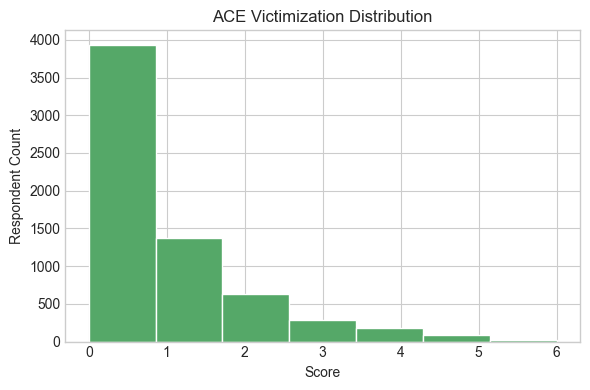

In [149]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(main_df["ace_victim"].dropna(), bins=7, color="#55a868", edgecolor="white")
ax.set_title("ACE Victimization Distribution")
ax.set_xlabel("Score")
ax.set_ylabel("Respondent Count")
fig.tight_layout()
plt.show()

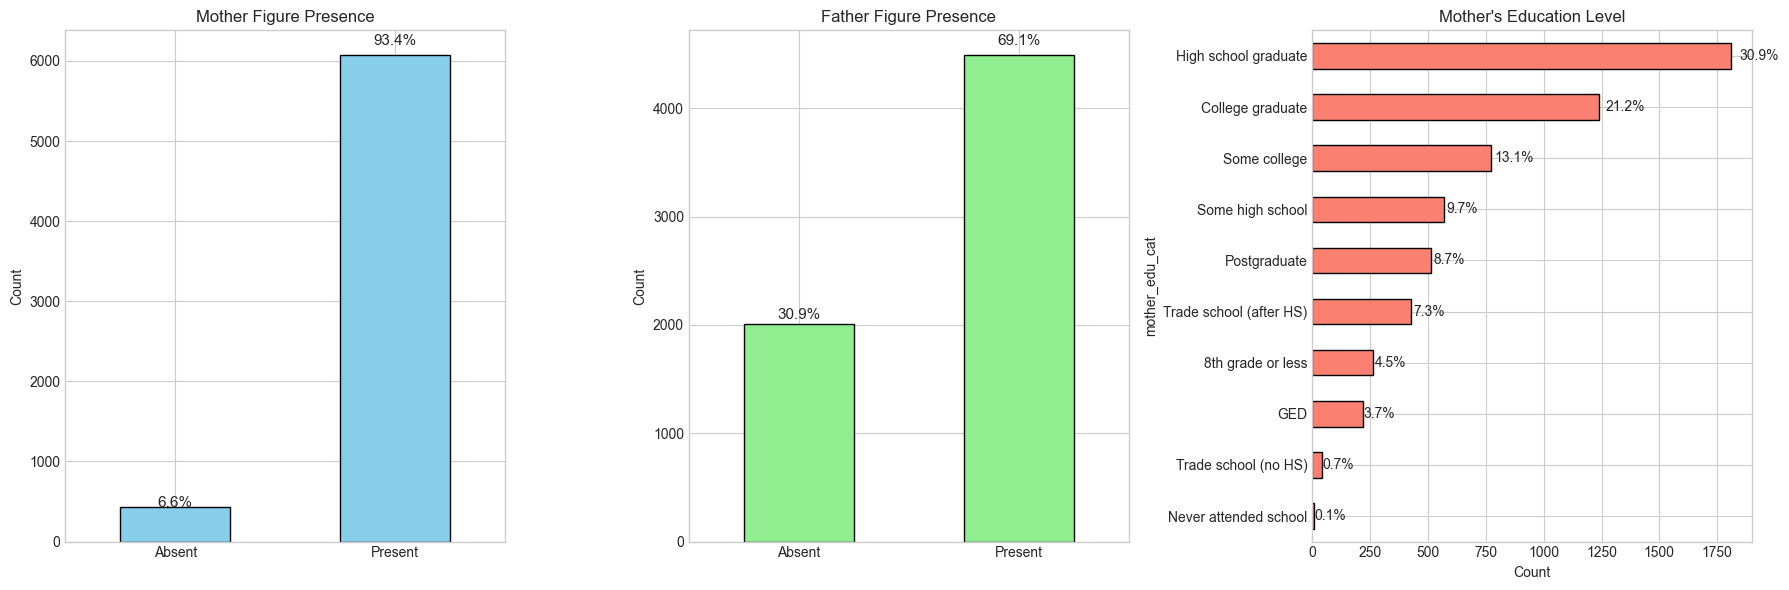

In [152]:
import matplotlib.pyplot as plt

# Set up the figure with 3 subplots side-by-side
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# --- 1. Mother Presence ---
# Get Counts
counts_m = eda_df['mother_present'].value_counts().sort_index()
counts_m.index = ['Absent', 'Present']
total_m = len(eda_df['mother_present'].dropna()) # Total for percentages

# Plot Counts
counts_m.plot(kind='bar', ax=ax[0], color='skyblue', edgecolor='black')

# Add Percentage Labels
for i, v in enumerate(counts_m):
    pct = (v / total_m) * 100
    ax[0].text(i, v + (v * 0.02), f'{pct:.1f}%', ha='center', fontsize=11)

ax[0].set_title('Mother Figure Presence')
ax[0].set_ylabel('Count')
ax[0].tick_params(axis='x', rotation=0)

# --- 2. Father Presence ---
# Get Counts
counts_f = eda_df['father_present'].value_counts().sort_index()
counts_f.index = ['Absent', 'Present']
total_f = len(eda_df['father_present'].dropna())

# Plot Counts
counts_f.plot(kind='bar', ax=ax[1], color='lightgreen', edgecolor='black')

# Add Percentage Labels
for i, v in enumerate(counts_f):
    pct = (v / total_f) * 100
    ax[1].text(i, v + (v * 0.02), f'{pct:.1f}%', ha='center', fontsize=11)

ax[1].set_title('Father Figure Presence')
ax[1].set_ylabel('Count')
ax[1].tick_params(axis='x', rotation=0)

# --- 3. Mother's Education ---
# Get Counts (Sorted by value so the chart looks organized)
counts_e = eda_df['mother_edu_cat'].value_counts().sort_values(ascending=True)
total_e = len(eda_df['mother_edu_cat'].dropna())

# Plot Counts (Horizontal)
counts_e.plot(kind='barh', ax=ax[2], color='salmon', edgecolor='black')

# Add Percentage Labels (logic is slightly different for horizontal bars)
for index, value in enumerate(counts_e):
    pct = (value / total_e) * 100
    # Place text to the right of the bar (value + offset)
    ax[2].text(value + (value * 0.02), index, f'{pct:.1f}%', va='center', fontsize=10)

ax[2].set_title("Mother's Education Level")
ax[2].set_xlabel('Count')

plt.tight_layout()
plt.show()

## Analysis and Next Steps taken:

- **Parental Warmth:** Right-skewed distribution, median is 2.82 (out of 6)
which means less respondants acquire high parental warmth.
- **Parental Monitoring:** Left-skewed distribution, median is 0.71 (out of 1)
which means more respondants are exposed to high parental monitoring
- **ACE Victimization:** very right-skewed, with most respondants not being exposed, or exposed to some ACEs.
- **Parental Figure Presence:** Mothers are present in pretty much every household, yet some households can be considered to be ran by single mothers (~30% of the houses have no father figure)
- **Mother's Education:** ~40% are highschool graduates, which shows a dominance of mothers with moderate education, while college graduates are at ~20%, which is the 2nd most frequent education level.

## Bivareate Relationships

Now we shall explore the relationship between our upbringing variables and suicide ideation, by plotting them against two groups:

- **Ideators**
- **Non-Ideators**

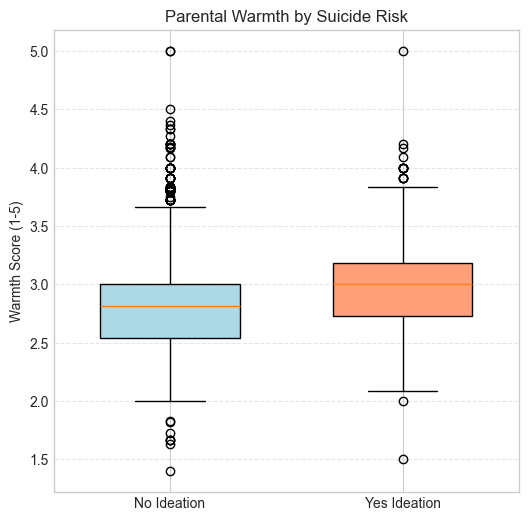

--- Statistics for parental_warmth ---
Mean Warmth (No Ideation):  2.83
Mean Warmth (Yes Ideation): 2.98
Difference: -0.15


In [158]:
# 1. Prepare Data
col = 'parental_warmth'
data_no = eda_df[eda_df['suicidal_ideation'] == 0][col].dropna()
data_yes = eda_df[eda_df['suicidal_ideation'] == 1][col].dropna()

# 2. Plot
plt.figure(figsize=(6, 6))
bplot = plt.boxplot([data_no, data_yes], tick_labels=['No Ideation', 'Yes Ideation'], 
                    patch_artist=True, widths=0.6)

# Color styling
colors = ['lightblue', 'lightsalmon']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Parental Warmth by Suicide Risk')
plt.ylabel('Warmth Score (1-5)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 3. Print Statistics
print(f"--- Statistics for {col} ---")
print(f"Mean Warmth (No Ideation):  {data_no.mean():.2f}")
print(f"Mean Warmth (Yes Ideation): {data_yes.mean():.2f}")
print(f"Difference: {data_no.mean() - data_yes.mean():.2f}")

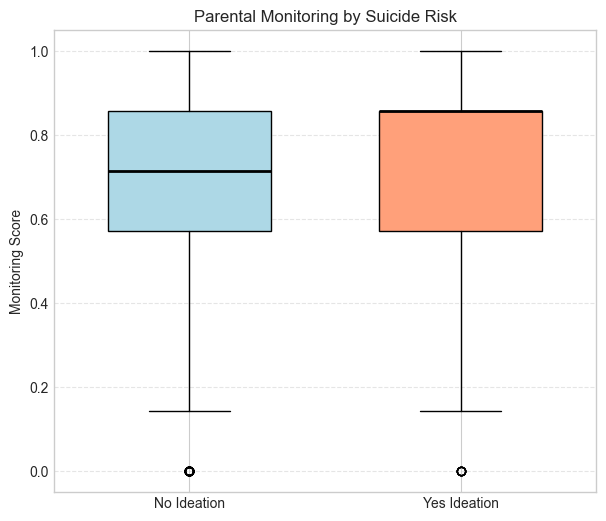

--- Statistics for parental_monitoring ---
Mean Monitoring (No Ideation):  0.73
Mean Monitoring (Yes Ideation): 0.74
Median Monitoring (No Ideation):  0.71
Median Monitoring (Yes Ideation): 0.86


In [160]:
# 1. Prepare Data
col = 'parental_monitoring'
data_no = eda_df[eda_df['suicidal_ideation'] == 0][col].dropna()
data_yes = eda_df[eda_df['suicidal_ideation'] == 1][col].dropna()

# 2. Plot
plt.figure(figsize=(7, 6))

# distinct changes: 
# added 'medianprops' to force the line to be Black and Thicker (linewidth=2)
bplot = plt.boxplot([data_no, data_yes], tick_labels=['No Ideation', 'Yes Ideation'], 
                    patch_artist=True, widths=0.6,
                    medianprops=dict(color="black", linewidth=2)) 

# Color styling (Light Blue vs Salmon)
colors = ['lightblue', 'lightsalmon']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Parental Monitoring by Suicide Risk')
plt.ylabel('Monitoring Score')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 3. Print Statistics
print(f"--- Statistics for {col} ---")
print(f"Mean Monitoring (No Ideation):  {data_no.mean():.2f}")
print(f"Mean Monitoring (Yes Ideation): {data_yes.mean():.2f}")
print(f"Median Monitoring (No Ideation):  {data_no.median():.2f}")
print(f"Median Monitoring (Yes Ideation): {data_yes.median():.2f}")

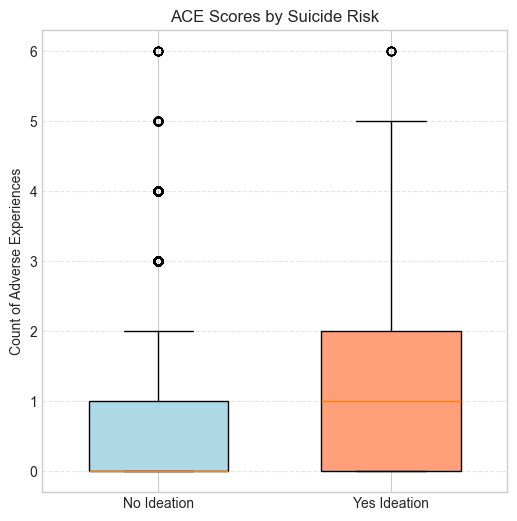

--- Statistics for ace_victim ---
Mean ACEs (No Ideation):  0.68
Mean ACEs (Yes Ideation): 1.13


In [161]:
# 1. Prepare Data
col = 'ace_victim'
data_no = eda_df[eda_df['suicidal_ideation'] == 0][col].dropna()
data_yes = eda_df[eda_df['suicidal_ideation'] == 1][col].dropna()

# 2. Plot
plt.figure(figsize=(6, 6))
bplot = plt.boxplot([data_no, data_yes], tick_labels=['No Ideation', 'Yes Ideation'], 
                    patch_artist=True, widths=0.6)

# Color styling
colors = ['lightblue', 'lightsalmon']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.title('ACE Scores by Suicide Risk')
plt.ylabel('Count of Adverse Experiences')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 3. Print Statistics
print(f"--- Statistics for {col} ---")
print(f"Mean ACEs (No Ideation):  {data_no.mean():.2f}")
print(f"Mean ACEs (Yes Ideation): {data_yes.mean():.2f}")

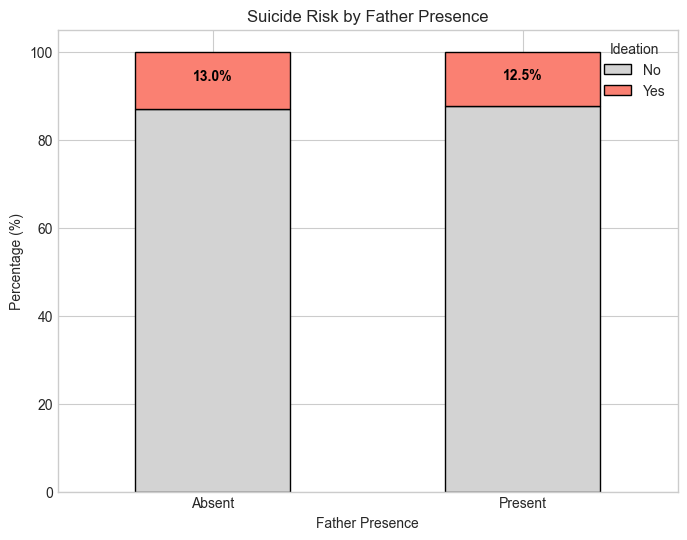

--- Risk Rates for father_present ---
Risk when Father Absent:  13.0%
Risk when Father Present: 12.5%


In [163]:
# 1. Calculate Cross-Tabulation
col = 'father_present'
ct = pd.crosstab(eda_df[col], eda_df['suicidal_ideation'], normalize='index') * 100

# 2. Plot
ax = ct.plot(kind='bar', stacked=True, color=['lightgray', 'salmon'], 
             figsize=(8, 6), edgecolor='black')

plt.title('Suicide Risk by Father Presence')
plt.ylabel('Percentage (%)')
plt.xlabel('Father Presence')
plt.xticks([0, 1], ['Absent', 'Present'], rotation=0)
plt.legend(title='Ideation', labels=['No', 'Yes'], loc='upper right')

# Add Labels
for n, x in enumerate(ct.index):
    risk_pct = ct.loc[x, 1]
    plt.text(n, 100 - (risk_pct/2), f'{risk_pct:.1f}%', ha='center', 
             color='black', fontweight='bold')

plt.show()

# 3. Print Statistics
print(f"--- Risk Rates for {col} ---")
print(f"Risk when Father Absent:  {ct.loc[0, 1]:.1f}%")
print(f"Risk when Father Present: {ct.loc[1, 1]:.1f}%")

<Figure size 800x600 with 0 Axes>

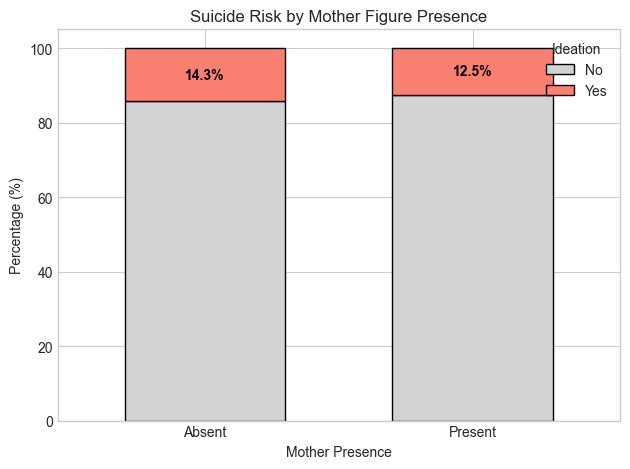

--- Risk Rates for mother_present ---
Risk when Mother Absent:  14.3%
Risk when Mother Present: 12.5%


In [165]:
# 1. Calculate Cross-Tabulation
# This creates a table showing the % of 'No' vs 'Yes' for Absent (0) and Present (1)
col = 'mother_present'
ct = pd.crosstab(eda_df[col], eda_df['suicidal_ideation'], normalize='index') * 100

# 2. Plot
plt.figure(figsize=(8, 6))
# Plotting the stacked bars: 0=Gray (No Ideation), 1=Salmon (Yes Ideation)
ax = ct.plot(kind='bar', stacked=True, color=['lightgray', 'salmon'], 
             edgecolor='black', width=0.6)

plt.title('Suicide Risk by Mother Figure Presence')
plt.ylabel('Percentage (%)')
plt.xlabel('Mother Presence')
# Replace 0/1 x-labels with text
plt.xticks([0, 1], ['Absent', 'Present'], rotation=0)
plt.legend(title='Ideation', labels=['No', 'Yes'], loc='upper right')

# 3. Add Percentage Labels to the "Yes" (Red) section
for n, x in enumerate(ct.index):
    risk_pct = ct.loc[x, 1]
    # Place text in the middle of the red bar section
    plt.text(n, 100 - (risk_pct/2), f'{risk_pct:.1f}%', ha='center', va='center', 
             color='black', fontweight='bold')

plt.tight_layout()
plt.show()

# 4. Print Statistics
print(f"--- Risk Rates for {col} ---")
# Check if we actually have data for both groups (0 and 1) before printing
if 0 in ct.index:
    print(f"Risk when Mother Absent:  {ct.loc[0, 1]:.1f}%")
else:
    print("Risk when Mother Absent:  No data available")

if 1 in ct.index:
    print(f"Risk when Mother Present: {ct.loc[1, 1]:.1f}%")

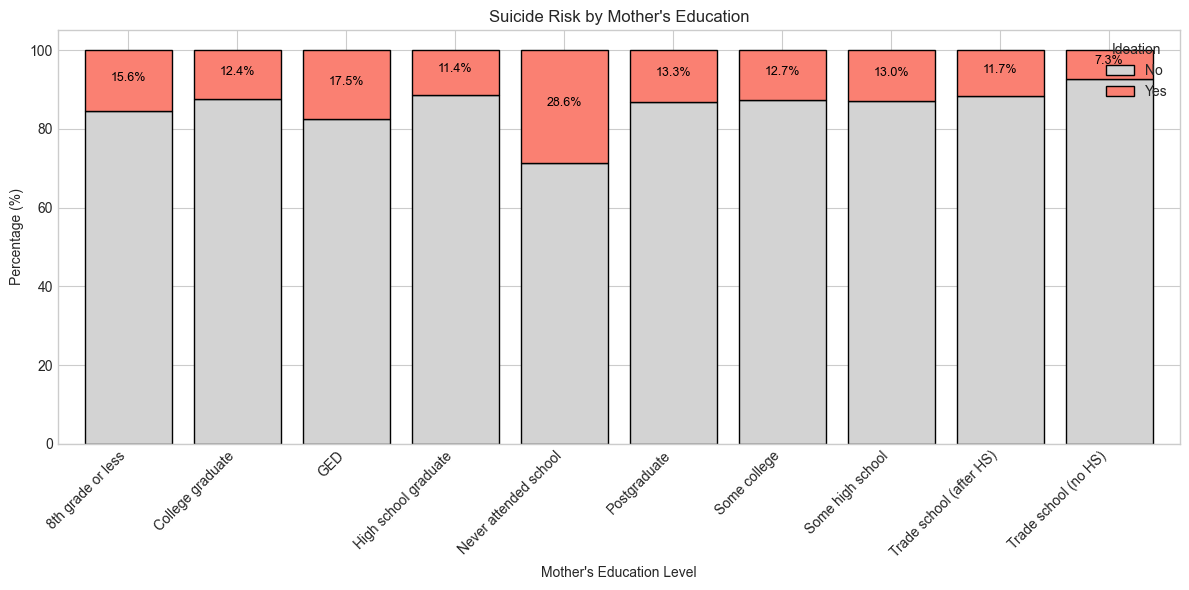

--- Risk Rates for mother_edu_cat (Top 3 & Bottom 3) ---
mother_edu_cat
Never attended school     28.57
GED                       17.51
8th grade or less         15.59
Postgraduate              13.28
Some high school          13.03
Some college              12.73
College graduate          12.41
Trade school (after HS)   11.74
High school graduate      11.37
Trade school (no HS)       7.32
Name: 1, dtype: float64


In [164]:
# 1. Calculate Cross-Tabulation
col = 'mother_edu_cat'
ct = pd.crosstab(eda_df[col], eda_df['suicidal_ideation'], normalize='index') * 100

# Optional: Sort by education level if your categories are ordinal strings
# ct = ct.sort_values(by=...) # Only needed if the order looks wrong

# 2. Plot
ax = ct.plot(kind='bar', stacked=True, color=['lightgray', 'salmon'], 
             figsize=(12, 6), edgecolor='black', width=0.8)

plt.title("Suicide Risk by Mother's Education")
plt.ylabel('Percentage (%)')
plt.xlabel("Mother's Education Level")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Ideation', labels=['No', 'Yes'], loc='upper right')

# Add Labels (Only if risk > 2% to avoid clutter)
for n, x in enumerate(ct.index):
    risk_pct = ct.loc[x, 1]
    if risk_pct > 2:
        plt.text(n, 100 - (risk_pct/2), f'{risk_pct:.1f}%', ha='center', 
                 color='black', fontsize=9)

plt.tight_layout()
plt.show()

# 3. Print Statistics
print(f"--- Risk Rates for {col} (Top 3 & Bottom 3) ---")
print(ct[1].sort_values(ascending=False))

In [ ]:
select_vars_data.boxplot(column="cesd_score", by="suicidal_ideation")
plt.title("CES-D Score by Suicidal Ideation")
plt.suptitle("")  
plt.xlabel("Suicidal Ideation")
plt.ylabel("CES-D Score")
plt.show()

In [ ]:
select_vars_data.boxplot(column="impulsivity", by="suicide_attempt")
plt.title("Impulsivity by Suicide Attempt")
plt.suptitle("")
plt.xlabel("Suicide Attempt")
plt.ylabel("Impulsivity")
plt.show()

In [ ]:
sample = select_vars_data.sample(n=800, random_state=42)
plt.scatter(sample["parental_warmth"], sample["cesd_score"], alpha=0.7)
plt.title("Parental Warmth vs CES-D (Sample of 1000)")
plt.xlabel("Parental Warmth")
plt.ylabel("CES-D Score")
plt.show()

In [ ]:
select_vars_data.boxplot(column="ace_victim", by="suicidal_ideation")
plt.title("ACE Count by Suicidal Ideation")
plt.suptitle("")
plt.xlabel("Suicidal Ideation")
plt.ylabel("ACE Count")
plt.show()

In [ ]:
# Check Poverty Density Bins
poverty_counts = eda_df['Poverty_density'].value_counts().sort_index()
plt.figure(figsize=(6, 4))
plt.bar(poverty_counts.index.astype(str), poverty_counts.values, color='lightgreen', edgecolor='black')
plt.title('Distribution of Neighborhood Poverty')
plt.xlabel('Poverty Level (Low -> High)')
plt.show()

In [ ]:
# Preparing data for Boxplot: Split the warmth scores by suicidal status
group_no = eda_df[eda_df['suicidal_ideation'] == 0]['parental_warmth'].dropna()
group_yes = eda_df[eda_df['suicidal_ideation'] == 1]['parental_warmth'].dropna()

plt.figure(figsize=(8, 6))
plt.boxplot([group_no, group_yes], tick_labels=['No Ideation', 'Yes Ideation'])
plt.title('Does Parental Warmth differ by Suicide Risk?')
plt.ylabel('Parental Warmth Score')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Median for parental warmth score is surprisingly greater for the group of repondants with suicidal ideation
# than those with no suicidal ideation. parental_warmth is not a string candidate for my model

In [ ]:
# 1. Round Parental Warmth to the nearest whole number (1.0, 2.0, 3.0, etc.)
# This groups "3.2" and "3.8" into the same "3" or "4" bucket.
main_df['warmth_rounded'] = main_df['parental_warmth'].round(0)

# 2. Create the pivot table using the ROUNDED variable
interaction_data = main_df.groupby(['warmth_rounded', 'Poverty_density'])['suicidal_ideation'].mean().unstack()

# 3. Plotting
ax = interaction_data.plot(kind='bar', figsize=(10, 6), color=['green', 'orange', 'red'], width=0.8)

plt.title('Suicide Risk by Parental Warmth and Neighborhood Poverty')
plt.xlabel('Parental Warmth Level (Rounded)')
plt.ylabel('Probability of Suicidal Ideation')
plt.legend(title='Poverty Density', labels=['Low', 'Medium', 'High'])

# Fix the x-axis labels to be horizontal and readable
plt.xticks(rotation=0) 
plt.grid(axis='y', alpha=0.3)

plt.show()

In [ ]:


# Prepare data
data_no = eda_df[eda_df['suicidal_ideation'] == 0]['parental_warmth'].dropna()
data_yes = eda_df[eda_df['suicidal_ideation'] == 1]['parental_warmth'].dropna()

plt.figure(figsize=(8, 6))
# Create violin plot (shows density + range)
parts = plt.violinplot([data_no, data_yes], showmedians=True)

# Styling for clarity
colors = ['green', 'red']
for pc, color in zip(parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_alpha(0.6)

plt.xticks([1, 2], ['No Ideation', 'Yes Ideation'])
plt.ylabel('Parental Warmth Score (1-5)')
plt.title('Is the "Yes" Group Bimodal? (Look for a dumbbell shape)')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

In [ ]:
from scipy.stats import mannwhitneyu

# Isolate the two groups
group_no = eda_df[eda_df['suicidal_ideation'] == 0]['parental_warmth'].dropna()
group_yes = eda_df[eda_df['suicidal_ideation'] == 1]['parental_warmth'].dropna()

# Run the test
stat, p_val = mannwhitneyu(group_yes, group_no, alternative='greater')

print(f"Median Warmth (No Ideation): {group_no.median()}")
print(f"Median Warmth (Yes Ideation): {group_yes.median()}")
print(f"P-value: {p_val:.5f}")

if p_val < 0.05:
    print("CONCLUSION: The 'Higher Warmth' in the suicidal group is STATISTICALLY SIGNIFICANT.")
else:
    print("CONCLUSION: The difference is random noise. Ignore it.")

In [ ]:
# 1. Define the variable we are testing
variable_to_test = 'parental_monitoring'

# 2. Group by Poverty and Suicide Status to get the Mean Score
interaction_data = eda_df.groupby(['Poverty_density', 'suicidal_ideation'])[variable_to_test].mean().unstack()

# 3. Setup the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define width of bars
width = 0.35 
x = np.arange(len(interaction_data.index)) 

# 4. Create Side-by-Side Bars
# Green = No Ideation
rects1 = ax.bar(x - width/2, interaction_data[0], width, label='No Ideation', color='mediumseagreen')
# Red = Yes Ideation
rects2 = ax.bar(x + width/2, interaction_data[1], width, label='Yes Ideation', color='indianred')

# 5. Labeling
ax.set_ylabel(f'Average {variable_to_test.replace("_", " ").title()}')
ax.set_xlabel('Neighborhood Poverty Level')
ax.set_title(f'Interaction: Does Neighborhood Context Affect {variable_to_test.replace("_", " ").title()}?')
ax.set_xticks(x)
ax.set_xticklabels(['Low', 'Medium', 'High']) 
ax.legend(title='Suicidal Ideation')
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Dynamic Zoom: Set Y-limit based on the data range to make differences visible
min_val = eda_df[variable_to_test].min()
max_val = eda_df[variable_to_test].max()
# Zoom in to the middle 50% of the range or just around the means
mean_val = eda_df[variable_to_test].mean()
ax.set_ylim(mean_val - 1, mean_val + 1) 

plt.show()

## Hypotheses:
# Under Construction:

Since I have not yet found the enrichment data, this section is limited to stating some Hypotheses to be tested:

for all variables considered to be upbringing factors:

H0: This variable does not predict suicidal ideation among adolescents.
H1: This variable does predict suicidal ideation among adolescents.

For depression:

H0: CES-D depression scores do not predict suicidal ideation.

H1: Higher CES-D scores predict higher suicidal ideation.

For Impulsivity:

H0: Impulsivity does not predict suicidal ideation.

H1: Higher impulsivity predicts increased suicidal ideation.


(I ran out of time while searching for enrichment data, that is why this section is lacking)
- 